# IN4080: obligatory assignment 3

Mandatory assignment 3 consists of three parts. In Part 1, you will develop a chatbot model based on a basic retrieval-based model (25 points). In Part 2, you will implement a simple silence detector using speech processing (35 points). Finally, Part 3 will help you understand some core concepts in NLU and dialogue management through the construction of a simulated talking elevator (40 points).

You should answer all three parts. You are required to get at least 60 points to pass. The most important is that you try to answer each question (possibly with some mistakes), to help you gain a better and more concrete understanding of the topics covered during the lectures. 

- We assume that you have read and are familiar with IFI’s requirements and guidelines for mandatory assignments, see [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html) and [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-guidelines.html).
- This is an individual assignment. You should not deliver joint submissions. 
- You may redeliver in Devilry before the deadline (__Friday, November 11 at 23:59__), but include all files in the last delivery.
- Only the last delivery will be read! If you deliver more than one file, put them into a zip-archive. You don't have to include in your delivery the files already provided for this assignment. 
- Name your submission _your\_username\_in4080\_mandatory\_3_
- You can work on this assignment either on the IFI machines or on your own computer. 

The preferred format for the assignment is a completed version of this Jupyter notebook, containing both your code and explanations about the steps you followed. We want to stress that simply submitting code is __not__ by itself sufficient to complete the assignment - we expect the notebook to also contain explanations (in Norwegian or English) of what you have implemented, along with motivations for the choices you made along the way. Preferably use whole sentences, and mathematical formulas if necessary. Explaining in your own words (using concepts we have covered through in the lectures) what you have implemented and reflecting on your solution is an important part of the learning process - take it seriously!

__Technical tip__: Some of the tasks in this assignment will require you to extend methods in classes that are already partly implemented. To implement those methods directly in a Jupyter notebook, you can use the function `setattr` to attach a method to a given class: 

```python
class A:
    pass
a = A()

def foo(self):
    print('hello world!')
    
setattr(A, 'foo', foo)
```

## Part 1: Retrieval-based chatbot

We will build a retrieval-based chatbot based on a dialogue corpus of movie and TV subtitles. More specifically, we will rely on a pre-trained neural language model ([BERT](https://arxiv.org/abs/1810.04805)) to convert each utterance into a fixed-size vector. This conversion will allow us to easily determine the similarity between two utterances using cosine similarity. Based on this similarity metric, one can easily determine the utterance in the corpus that is most similar to a given user input. Once this most-similar utterance is found, the chatbot will select as response the following utterance in the corpus. 

To work on this chatbot, you need to install the `sentence-transformers` package (see [sentence-BERT](https://sbert.net) for details): 
```python
$ pip install --user sentence-transformers
```

### Data

We'll work with a dataset of movie and TV subtitles for English from the [OpenSubtitles 2018](https://opus.nlpl.eu/OpenSubtitles-v2018.php) dataset and restricted for this assignment to comedies. 

The dataset is in the gzip-compressed file `data/en-comedy.txt.gz`. The data contains one line per utterance. Dialogues from different movies or TV series are separated by lines starting with `###`.

The first task will be to read through the dataset in order to extract pairs of (input, response) utterances. We want to limit our extraction to ``high-quality'' pairs, and discard pairs that contain text that is not part of a dialogue, such as subtitles indicating _"(music in background)"_. We want to enforce the following criteria:
1. The two utterances should be consecutive, and part of the same movie/TV series.
2. `###` delimiters between movies or TV series should be discarded.
3. Pairs in which one utterance contains commas, parentheses, brackets, colons, semi-colons or double quotes should be discarded.
4. Pairs in which one utterance is entirely in uppercase should be discarded.
5. Pairs in which one utterance contains more than 10 words should be discarded.
6. Pairs in which one utterance contains a first name should be discarded (see the JSON file `first_names.json` to detect those), as those are typically names of characters occurring in the movie or TV series. 
7. Pairs in which the input utterance only contains one word should be discarded (as user inputs typically contain at least two words).

You can of course add your own criteria to further enhance the quality of the (input, response) pairs. If you want the chatbot to focus on a specific subset of movies (like TV episodes from the eighties) you are also free to do so. 

### Code

Here is the template code for our basic chatbot:

In [2]:
import os, random, gzip, json, re, sys
import numpy as np
import sentence_transformers
from typing import List, Tuple, Dict

try:
  DIALOGUE_FILE= os.path.join(os.path.dirname(__file__), "data", "en-comedy.txt.gz")
  FIRST_NAMES = os.path.join(os.path.dirname(__file__), "data", "first_names.json")
except NameError:
  dirname = os.path.dirname(sys.executable)
  DIALOGUE_FILE= os.path.join(os.path.dirname(dirname), "data", "en-comedy.txt.gz")
  FIRST_NAMES = os.path.join(os.path.dirname(dirname), "data", "first_names.json")

SBERT_MODEL = "all-MiniLM-L6-v2"

class Chatbot:
    """A basic, retrieval-based chatbot"""
    
    def __init__(self, dialogue_data_file=DIALOGUE_FILE, embedding_model_name=SBERT_MODEL):
        """Initialises the retrieval-based chatbot with a corpus and an embedding model
        from sentence-transformers."""
        
        # Load the embedding model
        self.model = sentence_transformers.SentenceTransformer(embedding_model_name)
        
        # Extracts the (input, response) pairs
        self.pairs = self._extract_pairs(dialogue_data_file)
        
        # Precompute the embeddings for each input utterance in the pairs
        self.input_embeddings = self._precompute_embeddings()
        
    
    def _extract_pairs(self, dialogue_data_file:str, max_nb_pairs:int=25000) -> List[Tuple[str,str]]:
        """Given a file containing dialogue data, extracts a list of relevant
        (input,response) pairs, where both the input and response are
        strings. The 'input' is here simply the first utterance (such as a question),
        and the 'response' the following utterance (such as an answer).
        
        The (input, response) pairs should satisfy the following critera:
        - The two strings should be consecutive, and part of the same movie/TV series
        - Pairs in which one string contains commas, parentheses, brackets, colons, 
          semi-colons  or double quotes should be discarded.
        - Pairs in which one string is entirely in uppercase should be discarded
        - Pairs in which one string contains more than 10 words should be discarded
        - Pairs in which one string contains a first name should be discarded 
          (see the json file FIRST_NAMES to detect those).
        - Pairs in which the input string only contains one token should be discarded.
          
        You are of course free to add additional critera to increase the quality of your
        (input, response) pairs. You should stop the extract once you have reached 
        max_nb_pairs.
        
        """
        raise NotImplementedError()
    
    
    def _precompute_embeddings(self) -> np.ndarray :
        """Based on the sentence-BERT model in self.model, computes the vectors associated with 
        each input string of the (input, response) pairs in self.pairs. You can ignore the response 
        string of each pair. The method should return a numpy matrix of dimension (N, d) where N is 
        the number of elements in self.pairs, and d is the dimension of the output vector 
        (for instance 384).
        
        The vectors can be computed through the method self.model.encode(...), which can take
        either a single string or a list of strings (note, however, that you may receive an
        out-of-memory error if the provided list of strings is too large for the model).
        """
        
        raise NotImplementedError()
       
        
    def get_response(self, user_utterance: str) -> str:
        """
        Extracts the vector for the user utterance using the sentence-BERT model in self.model, 
        and then computes the cosine similarity of this vector against the vectors of all inputs
        in the (input, response) pairs, which should be precomputed in self.input_embeddings. 
        
        After computing those cosine similarity scores, the method should find the input that
        is most similar to the user utterance, and then select the corresponding response -- that is,
        the response in the (input, response) pair. 
        
        You should try to implement this method using Numpy functions, without any explicit loop.
        
        The method returns a string with the response of the chatbot.
        """
        raise NotImplementedError()



### Initialisation
 
The initialisation of the chatbot operates in two steps. The first step, represented by the method  `_extract_pairs` is to read the corpus in order to extract a list of (input, response) pairs that satisfy the seven quality criteria mentioned above. Given those pairs, the chatbot then calculates in `_precompute_embeddings` the vectors of all input utterances in those pairs using the `encode` method of the pre-trained sentence-BERT model. Note that we only need to compute the vectors for the inputs, not for the responses! 

__Task 1.1__: Implement the method `_extract_pairs`.


In [7]:
def line_is_ok(line, names):
  """Checks if text line follows the principles stated in the assignment. 

  Args:
      line (str): string from data. 
      names (list): list of names that is used to exclude strings. 

  Returns:
      bool: returns True if the line of text is considered ok for use. 
  """
  forbidden_symbols = ",()[]:;\""
  # check if the forbidden symbols are in the line
  if any(c in forbidden_symbols for c in line):
    return False
  # split line into list
  line_as_list = line.split(" ")
  # check if line is uppercase
  if line.isupper():
    return False
  # check if line is longer than 10
  if len(line_as_list) > 10:
    return False
  # check if line contains any of the names in the list
  if any(word in names for word in line_as_list):
    return False

  return True


def _extract_pairs(self, dialogue_data_file:str, max_nb_pairs:int=25000):
    # load names from json file
    with open(FIRST_NAMES,"r") as f:
        names = json.load(f)
    
    # assumes data file is a .gz file
    f = gzip.open(dialogue_data_file, "rt")
    sent_pairs = []

    while len(sent_pairs) < max_nb_pairs:
        line1 = f.readline()

        # if line starts with ### it's a descriptive line and we
        # should move on the next one
        if line1.startswith("###"):
            continue
        
        line2 = f.readline()
        # if the second line starts with ### we should forget 
        # the first and the second line. 
        if line2.startswith("###"):
            continue
        
        # checks whether the first line consists of only one word
        if len(line1.split(" ")) == 1:
            continue
        
        # if both lines fullfill the condtions they are appended to
        # sent_pairs as a Tuple[str, str]
        if line_is_ok(line1, names) and line_is_ok(line2, names):
            sent_pairs.append((line1.strip(), line2.strip()))

    f.close()

    return sent_pairs

setattr(Chatbot, '_extract_pairs', _extract_pairs)


__Task 1.2__: Implement the method `_precompute_embeddings`.


In [8]:
def _precompute_embeddings(self):
    # encodes the question string in the list of tuples
    return self.model.encode([s[0] for s in self.pairs])
    
setattr(Chatbot, '_precompute_embeddings', _precompute_embeddings)


### Runtime

Once those pairs and corresponding vectors are extracted, we only need to implement the logic for selecting the most appropriate response for a new user input. In this simple, retrieval-based chatbot, we will adopt the following strategy:
- we first extract the vector for the new user utterance using the sentence-BERT model
- we then compute the cosine similarities between this vector and the (precomputed) vectors of all inputs in the corpus
- we search for the input with the highest cosine similarity (= the utterance in the corpus that is most similar to the new user input)
- finally, we retrieve the response associated with this input utterance, and return it

__Task 1.3.__: Implement the method `get_response`.


In [9]:
def cosine_sim(a, b):
    # uses numpy to calculate cosine simiarity with broacasting
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))


def get_response(self, user_utterance:str):
    # encodes the user utterance
    enc_user_utterance = self.model.encode(user_utterance)
    # calculate cosine sim. of all the inputs embeddings and the encoded
    # user utterence
    cosine_sims = cosine_sim(self.input_embeddings, enc_user_utterance)
    # find the input embedding that is most similair to the user utterance
    idx_best_fit = np.argmax(cosine_sims)
    # return the response to the input embedding that is most similair 
    return self.pairs[idx_best_fit][1]
    
setattr(Chatbot, 'get_response', get_response)


_Technical tip_: When working with numpy arrays/matrices, you should always try to avoid going through explicit loops, as looping over values of a numpy array is highly inefficient. For instance, instead of computing the dot product of each input one after the other (within a loop), you can compute the dot product of all inputs in one single dot product operation -- which is way more efficient!  See [here](https://realpython.com/numpy-array-programming/) for more details on the best way to work with numpy arrays.  

## Part 2: speech processing


In this part, we will learn how we can perform basic speech processing using operations on numpy arrays! We'll work with `wav` files. 

A `wav` file is technically quite simple and encodes a sequence of integers, where each integer express the magnitude of the signal at a given time slice. The number of time slices per second is defined in the frame rate, which is often 8kHz, 16kHz or 44.1kHz. So a file with 4 seconds of audio using a frame rate of 16 kHz will have a sequence of 64 000 integers. The number of bits used to encode these integers may be 8-bit, 16-bit or 32-bit (more bits means that the quantization of the signal at each time slice will be more precise, as there will be more levels). Finally, a `wav` file may be either mono (one single audio channel) or stereo (two distinct audio channels, each with its sequence of integers). 

To read the audio data from a `wav` file, you can use `scipy`:

In [3]:
import scipy.io.wavfile
fs, data = scipy.io.wavfile.read("data/excerpt.wav")
data = data.astype(np.int32)

where `data` is the numpy array containing the actual audio data, and `fs` is the frame rate. Note that I am here converting the integers into 32-bit to avoid running into overflow problems later on (i.e.~when squaring the values).


__Task 2.1__: Plot (using [`matplotlib.pyplot`](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)) the waveform for the full audio clip. 
 

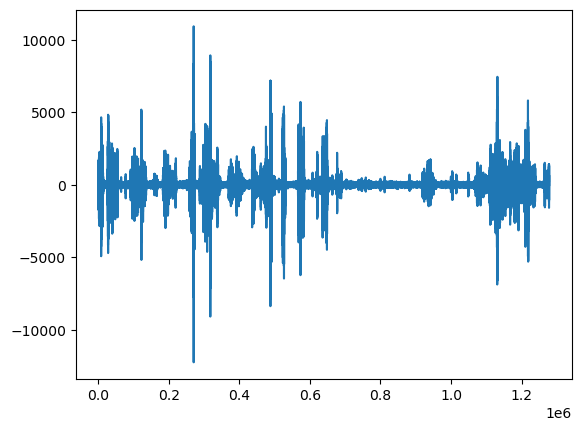

In [4]:
import matplotlib.pyplot as plt

plt.plot(data)

For speech analysis, looking directly at the signal magnitude is typically not very useful, as we can't typically distinguish speech sounds based on the waveform. A representation of the signal that is much more amenable to speech analysis is the _spectrogram_, which represents the spectrum of _frequencies_ of a signal as it varies with time.

__Task 2.2__: Plot the spectrogram of the first second of the audio clip, using the function [`matplotlib.pyplot.specgram`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html).    

(array([[7.03623837e-02, 2.83807284e+01, 5.85543284e+00, ...,
         1.34919884e+01, 3.79396590e+00, 6.36884866e+01],
        [2.21021405e+00, 9.15554085e+00, 2.75431168e+01, ...,
         3.03985649e+01, 8.21889658e+00, 6.30085952e+01],
        [3.88946237e+01, 2.25135277e+01, 1.56653050e+00, ...,
         5.17578592e+01, 2.29748297e+01, 9.66962596e+00],
        ...,
        [7.58621390e-03, 7.28476186e-04, 1.72324800e-03, ...,
         5.76995787e-03, 2.63200494e-03, 3.07827502e-03],
        [2.32646274e-03, 5.75947407e-03, 4.99808958e-04, ...,
         3.93738064e-03, 1.93213569e-03, 1.49916364e-03],
        [4.08091200e-04, 5.55955311e-03, 1.06250278e-03, ...,
         4.64519971e-05, 4.89262291e-04, 8.01500803e-04]]),
 array([   0. ,   62.5,  125. ,  187.5,  250. ,  312.5,  375. ,  437.5,
         500. ,  562.5,  625. ,  687.5,  750. ,  812.5,  875. ,  937.5,
        1000. , 1062.5, 1125. , 1187.5, 1250. , 1312.5, 1375. , 1437.5,
        1500. , 1562.5, 1625. , 1687.5, 1750. , 1

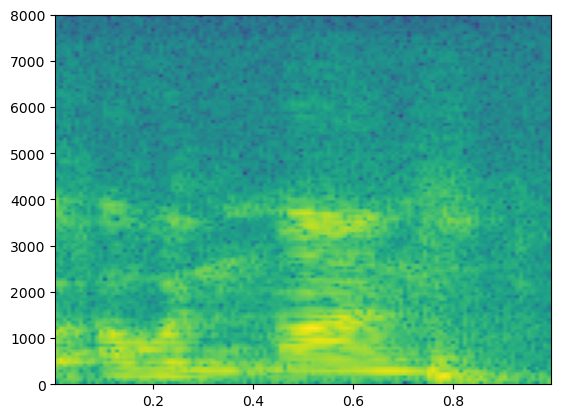

In [5]:
# the number of time slices per second is defined by the frame rate
# frame rate = 16kHz -> data[:16_000] is first second

plt.specgram(data[:16_000], Fs=fs)

Now, let's say we wish to remove periods of silence from the audio clip. There are many methods to detect silence (including deep neural networks), but we will rely here on a simple calculation based on the energy of the signal, which is the sum of the square of the magnitudes for each value within a frame:
\begin{equation}
    E = \sum_{i=1}^N X[t]^2
\end{equation}

__Task 2.3__: Loop on your audio data by moving a frame of 200 ms. with a step of 100 ms., as shown in the image below. For each frame, compute the energy as in Eq. (1) and store the result.

<div>
<center>
<img src="https://home.nr.no/~plison/img/waveform.png" alt="Moving window on audio data" width="600px"/>
</center></div>


In [6]:
# task 2.3

# 1 s = 1 000 ms 
# frame = 200ms, step = 100ms
# 0:16_000 = 1 sec -> 0:16_000/5 = 200 ms = 0:3_200

energy_per_frame = []
start_idx = 0
# iterating the data in slices and summing over each slize
# the sum is considered a frame, and is added to the 
# energy_per_frame list. 
for end_idx in range(3_200, data.shape[0], 1_600):
  audio_slice = data[start_idx:end_idx]
  energy = sum(audio_slice**2)
  energy_per_frame.append(energy)
  start_idx += 1_600

__Task 2.4__: Now that we have the energy for each frame of the audio clip, we can calculate the mean energy per frame, and define silent frames as frames that have less than $\frac{1}{10}$ of this mean energy. Determine which frame is defined as silent according to this definition.
Show on the plot of the waveform which segment is determined as silent, using the method [`matplotlib.pyplot.hlines`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hlines.html). 

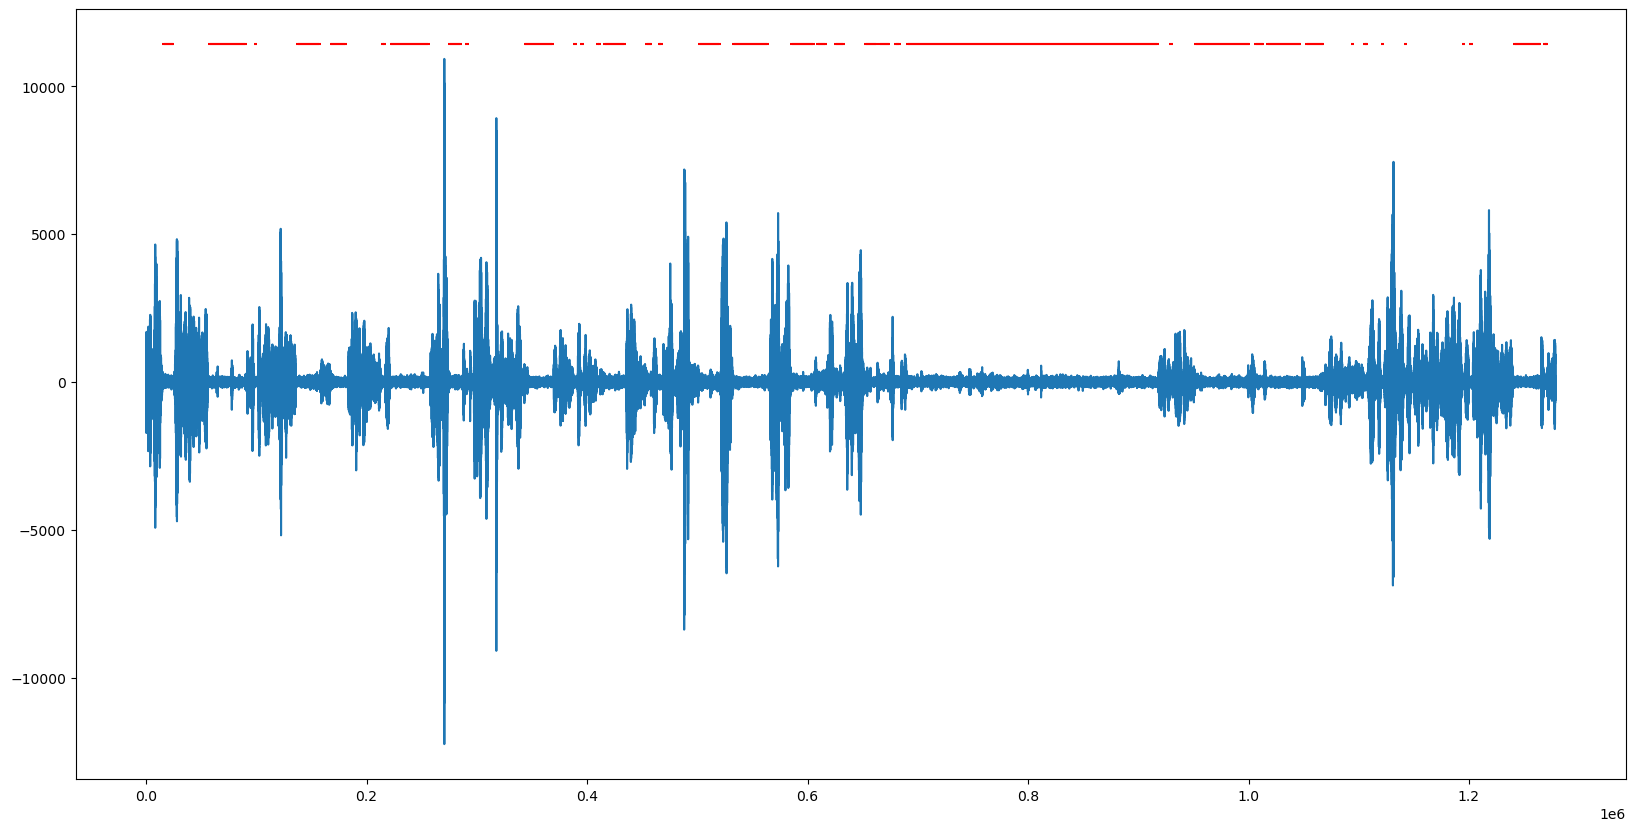

In [7]:
# calculate mean energy
mean_energy = np.mean(energy_per_frame)
# calculate energy treshold
energy_treshold = mean_energy / 10
# if energy is greater than energy_treshold the frame is 
# considered not silent. 
sound = [energy > energy_treshold for energy in energy_per_frame]

fig, ax = plt.subplots(figsize=(20, 10))

# same window as before
start_idx = 0
end_idx = 3_200

for i,frame in enumerate(sound):

  if not frame:
    # make the red line
    ax.hlines(max(data) + 500, start_idx, end_idx, color="r")

  start_idx, end_idx = start_idx + 1_600, end_idx + 1_600

ax.plot(data)

plt.show()

__Task 2.5__: If your calculations are correct, you will notice that the method has marked many short, isolated segments (e.g.~in the middle of a word) as silent. We want to avoid this of course, so we will rely on a stricter requirement to define whether a frame should be considered silent or not: we only mark a frame as silent if the frame _and all of its neighbouring frames_ have less than $\frac{1}{10}$ of the mean energy. We can defines the neighbourhood of a frame as the five frames before and the five frames after.  Show again on the plot of the waveform which segment is determined as silent using the stricter definition above. 


In [8]:
# task 2.5

def find_silence(energy, treshold, frames2consider = 5):
  # add padding of 5 on each side, will set to 0
  # then iterate energy list
  #   if energy[i] is greater than the treshold do
  #     check 5 neighbours back and forward
  #     if all of them are less then treshold 
  #     energy[i] is considered silence 

  pads = [0 for i in range(frames2consider)]
  padded_energy = pads + energy + pads
  sound = []

  for i in range(4, len(energy) + frames2consider):
    if all([padded_energy[i] > treshold for i in range(i - 5, i + 6)]):
      sound.append(True)
    else:
      sound.append(False)

  return sound

In [9]:
sound_adv = find_silence(energy_per_frame, energy_treshold)

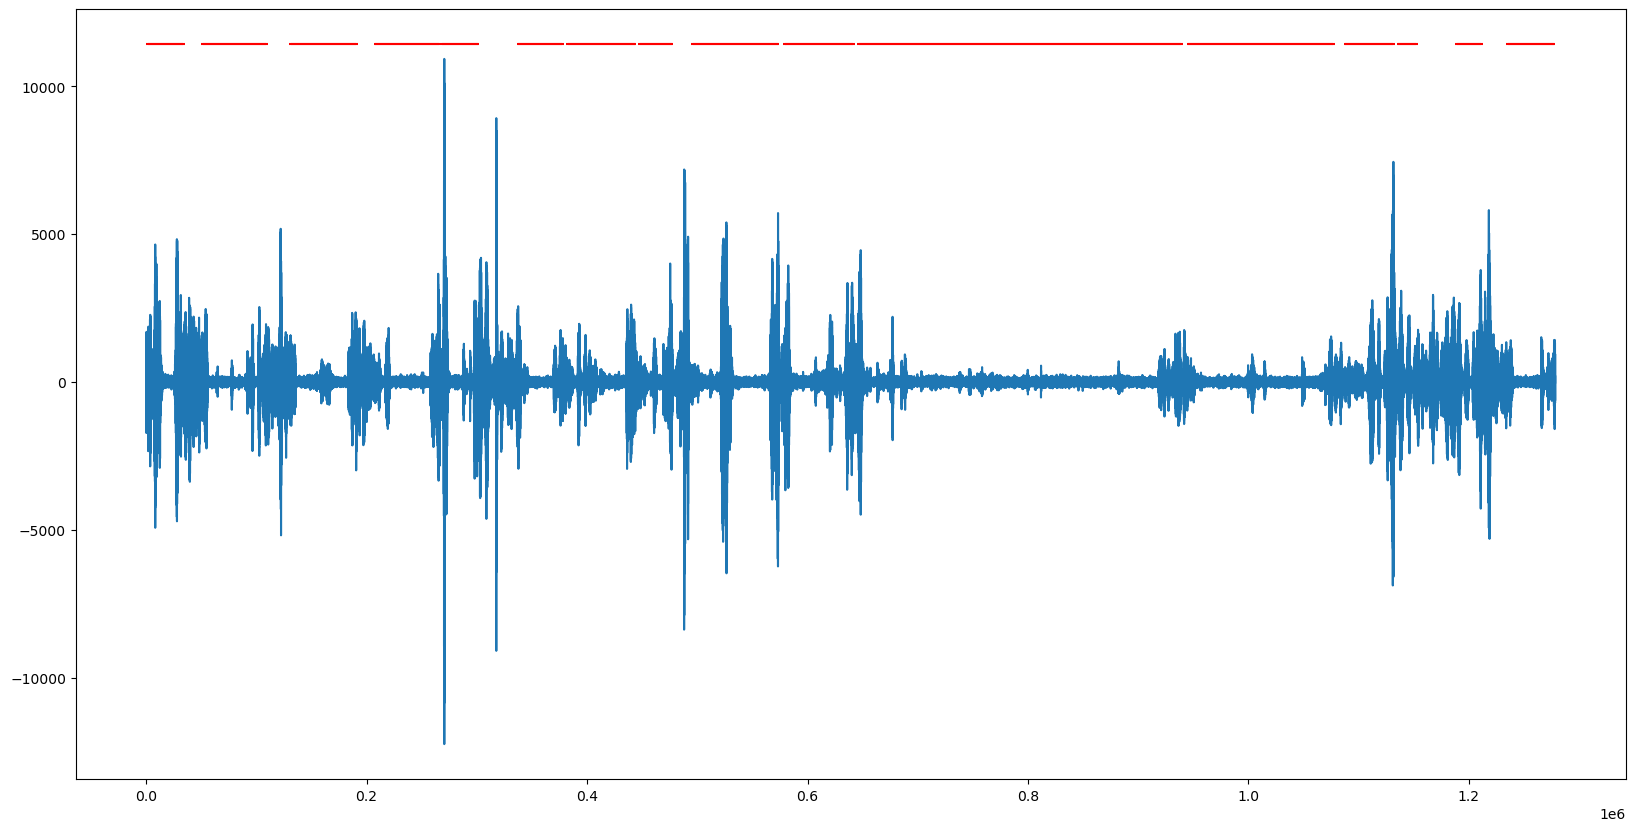

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))

start_idx = 0
end_idx = 3_200

for i,frame in enumerate(sound_adv):

  if not frame:
    ax.hlines(max(data) + 500, start_idx, end_idx, color="r")

  start_idx, end_idx = start_idx + 1_600, end_idx + 1_600

ax.plot(data)

plt.show()

__Task 2.5b__ (Optional): Modify the audio data by cutting out frames marked as silent, and using the method [`scipy.io.wavfile.write`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html) to write back the data into a `wav` file. Don't forget to convert back the data array to 16-bit using `astype(np.int16)` before saving the data to the `wav` file. 


__Task 2.6__ (Optional, for the bravest students): Until now, we have only looked at the detection of silent frames. But what we are truly interested in is to distinguish between speech sound and the rest, which may be either silence or non-speech sounds (noise). For this, we need to analyse the audio in the _frequency domain_ and look at which range of frequencies is most active within a given frame.

How do we achieve this? The key is to apply a _Fast Fourier Transform_ (FFT) to go from an audio signal expressed in the time domain to its corresponding representation in the frequency domain. We can then look at frequencies in the speech range (typically between 300 Hz and 3000 Hz) and compute the total energy associated to that range. You can look [here](https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html) to know more about how to use `numpy` and `scipy` to perform such operations. 

This task is not part of the obligatory assignment, but feel free to experiment with it if you are interested in audio processing. Students that manage to come with a solution for detecting silence and non-speech frames using FFT will get a bonus of +15 points.


## Part 3: Talking Elevator

Let's assume you wish to integrate a (spoken) conversational interface to one of the elevators in the IFI building. The elevator should include the following functions: 
- If the user express a wish to go to floor $X$ (where $X$ is an integer value between 1 and 10), the elevator should go to that floor. The interface should allow for several ways to express a given intent, such as "_Please go to the $X$-th floor_" or "_Floor $X$, please_".
- The user requests can also be relative, for instance "_Go one floor up_".
- The elevator should provide _grounding_ feedback to the user. For instance, it should respond "_Ok, going to the $X$-th floor_" after a user request to move to $X$.  
- The elevator should handle misunderstandings and uncertainties, e.g. by requesting the user to repeat, or asking the user to confirm if the intent is uncertain (say, when its confidence score is lower than 0.7). 
- The elevator should also allow the user to ask where the office of a given employee is located. For instance, the user could ask "_where is Erik Velldal's office?_", and the elevator would provide a response such as "_The office of Erik Velldal is on the 4th floor. Do you wish to go there?_".  Of course, you don't need to write down the office locations of all employees in the IFI department, just a few names will suffice for this prototype.  
- The elevator should also be able to inform the user about the current floor (such as replying to "_Which floor are we on?_" or "_Are we on the 5th floor?_"). 
- Finally, if the user asks the elevator to stop (or if the user says "_no_" after a grounding feedback "_Ok, going to floor $X$._"), the elevator should stop, and ask for clarification regarding the actual user intent. 


### Code

Here is the basic template for the implementation:

In [16]:
import re
import numpy as np
from typing import List, Tuple, Dict, Set
from elevator_utils import TalkingElevatorGUI, DialogueTurn
from sklearn.linear_model import LogisticRegression
    
class TalkingElevator:
    """Representation of a talking elevator. The elevator is simulated using a GUI
    implemented in elevator_utils (which should not be modified) """
    
    def __init__(self):
        """Initialised a new elevator, placed on the first floor"""
        
        # Current floor of the elevator
        self.cur_floor: int = 1
        
        # (Possibly empty) list of next floor stops to reach 
        self.next_stops : List[int] = []
        
        # Dialogue history, as a list of turns (from user and system)
        self.dialogue_history : List[DialogueTurn] = []
        
        # Initialises and start the Tkinter GUI
        self.gui = TalkingElevatorGUI(self)
        
        
    def start(self):
        "Starts the elevator"
        
        self._say_to_user("Greetings, human! What can I do for you?")
        self.gui.start()

        
    def process_user_input(self, user_turn : DialogueTurn):
        """Process a new dialogue turn from the user"""
        
        # We log the user input into the dialogue history and show it in the GUI
        self.dialogue_history.append(user_turn)
        self.gui.display_turn(user_turn)
        
        # We extract the intent distribution given the user input
        intent_distrib = self._get_intent_distrib(user_turn.utterance)
        
        # We take into account the confidence score of that input
        intent_distrib = {intent:prob * user_turn.confidence for intent, prob in intent_distrib.items()}
        
        # We extract the (possibly empty) set of detected slot values in the input
        slot_values = self._fill_slots(user_turn.utterance)
        
        # Finally, we execute the most appropriate response(s) given the 
        # intent distribution and detected entities
        self._respond(intent_distrib, slot_values)
        
        
    def train_intent_classifier(self, training_data: List[Tuple[str, str]]):
        """Given a set of (synthetic) user utterances labelled with their corresponding
        intent, train an intent classifier. We suggest you adopt a simple approach
        and use a logistic regression model with bag-of-words features. This implies
        you will need to:
        - construct a vocabulary list from your training data (and store it in the object)
        - create a small function that extracts bag-of-words features from an utterance
        - create and fit a logistic regression model with the training data (and store it)
        -""" 
        
        raise NotImplementedError
        
        
    def _get_intent_distrib(self, user_input:str) -> Dict[str, float]:
        """Given a user input, run the trained intent classifier to determine the 
        probability distribution over possible intents"""
        
        raise NotImplementedError
    
    def _fill_slots(self, user_input:str) -> Dict[str,str]:
        """Given a user input, run the rule-based slot-filling function to detect 
        the occurrence of a slot value. The method returns a (possibly empty)
        mapping from slot_name to the detected slot value, such as {floor_number:6}. 
        It is up to you to decide on the slots you want to cover in your
        implementation"""
        
        raise NotImplementedError
    
    def _respond(self, intent_distrib: Dict[str, float], slots: Dict[str,str]) :
        """Given an intent distribution and set of detected slots, and the 
        general state of the task and interaction (provided by the dialogue history, 
        current floor, next stops, and possibly other state variables you might want to 
        include), determine what to say and/or do, and execute those actions. In practice, 
        this method should consist of calls to the following methods:
        - _say_to_user(system_response): say something back to the user
        - _move_to_floor(floor_number): move to a given floor
        - _stop(): stop the current movement of the elevator """
        
        raise NotImplementedError
    
    def _say_to_user(self, system_response: str):
        """Say something back to the user, and add the dialogue turn to the history"""
        
        # We create a new system turn        
        system_turn = DialogueTurn(speaker_name="Elevator", utterance=system_response)

        # We add the system turn to the dialogue history and show it in the GUI
        self.dialogue_history.append(system_turn)
        self.gui.display_turn(system_turn)
    
    
    def _move_to_floor(self, floor_number : int):
        """Move to a given floor (by adding it to a stack of floors to reach)"""
        
        self.next_stops.append(floor_number)
        self.gui.trigger_movement()
        
        
    def _stop(self):
        """Stops all movements of the elevator"""
        
        self.next_stops.clear()
        self.gui.trigger_movement()
                


You can then simply run the elevator by starting a new `TalkingElevator` instance:

In [ ]:
elevator = TalkingElevator()
elevator.start()

Note that you need to run Jupyter _locally_ in order to start the GUI window (otherwise you may get a display error). To make things simple, the actual interface is text-based, but to simulate the occurrence of speech recognition errors, the implementation introduces some artificial noise into the user utterances (e.g.~swapping some random letters from time to time). Each user utterance comes associated with a confidence score (which would come from a speech recogniser in a real system, but is here also artificially generated).


### Intent recognition

Once a new user input is received, the first step is to recognise the underlying intent -- or, to be more precise, to produce a probability distribution over possible intents. 

__Task 3.1__: You first need to define a list of user intents that cover the kinds of user inputs you would expect in your application, such as `RequestMoveToFloor` or `Confirm`. This is a design question, and there is no obvious right or wrong answer. Define below the intents you want to cover, along with an explanation and a few examples of user inputs for each.

### __Answer 3.1__

There will be 7 different classes:
  0. Move up relative to current floor. 
  1. Move down relative to current floor. 
  2. Move to a given floor. 
  3. Request what floor a professor works at. 
  4. Request what floor the elevator is currently situated on. 
  5. Confirmation.
  6. Denial. 


Below have listed class label as integers and strings, together with a couple of examples of what the input might look like. 


0. move_relative_up; move one up, two up, ...
1. move_relative_down; move one down, two down, ...
2. move_absolute; move to tenth floor, move to first floor, ...
3. request_prof_floor; what floor is Prof. X on?, Take me to Prof. Ys floor,..
4. req_curr_floor; what floor are we on, what's the current floor,...
5. confirm; yes, sure, ..
6. deny; no, stop it, ...


__Task 3.2__: We wish to build a classifier any user input to a probability distribution over those intents, and start by creating a small, synthetic training set. Make a list of at least 50 user utterances, each labelled with an intent defined above. You can "make up" those utterances yourself, or ask someone else to come with alternative formulations if you lack inspiration.

In [11]:
# I have listed some associates with the faculty of informatics. This 
# list is mostly to keep track of which associates that will be present
# in the data.  
profs = [
    "Pierre Lison", 
    "Erik Velldal", 
    "Roar Skogstrøm", 
    "Ole Jakob Elle", 
    "Andreas Austeng"
]


"""
NOTE: 
0. move_relative_up
1. move_relative_down
2. move_absolute
3. request_prof_floor
4. req_curr_floor
5. confirm
6. deny
"""

# data for intent model
labelled_utterances = [
    ["1 floor up please", 0],
    ["Up 2 floors, thank you", 0],
    ["3 floors up!", 0],
    ["3 floors up.", 0],
    ["4 floors up.", 0],
    ["Take me 5 floors up.", 0],
    ["6 floors up.", 0],
    ["7 up.", 0],
    ["8 up.", 0],
    ["Take me 9 floors up.", 0],
    ["7 up.", 0],
    ["Go 1 floor upward, please.", 0],
    ["4 floors upwards.", 0],
    

    ["I would like to go down 1 floor", 1],
    ["2 floors down", 1],
    ["Go down 3 floors.", 1],
    ["Go down 3 floors, please.", 1],
    ["Take me down 3 floors.", 1],
    ["Take me down 4 floors.", 1],
    ["5 down, please.", 1],
    ["I would like to go down 6 floors.", 1],
    ["7 floors down", 1],
    ["Please, 8 floors downward.", 1],
    ["Please, 9 floors down.", 1],
    

    ["Please, move to floor 5", 2],
    ["To the fourth floor mr Robot man", 2],
    ["Floor 3.", 2],
    ["Sixth.", 2],
    ["Please, move to floor 5", 2],
    ["Please, move to floor 3", 2],
    ["I would like to go to the second floor", 2],
    ["Go to the third floor now", 2],
    ["Take me to the tenth floor", 2],
    ["Tenth floor, please", 2],
    ["First floor", 2],
    ["Second floor.", 2],
    ["First floor.", 2],
    ["Sixth floor, please.", 2],
    ["I would like to go to the ninth floor.", 2],


    ["At what floor is Pierre Lison's office?", 3],
    ["Where's Andreas Austengs office?", 3],
    ["Go to Ole Jakob Elle's floor.", 3],
    ["Roar Skogstrøm's office", 3],
    ["Roar Skogstrøm's floor", 3],
    ["Ole Jakob Elle", 3],
    ["Roar's office.", 3],
    ["Pierre's office.", 3],


    ["What's the current floor?", 4],
    ["Is this the 5th floor?", 4],
    ["What floor are we on?", 4],
    ["What floor?", 4],
    ["What is the current floor?", 4],


    ["Stop it!", 5],
    ["No, don't do that.", 5],
    ["You misunderstood", 5],
    ["Nope.", 5],
    ["That's incorrect.", 5],
    ["Stop.", 5],


    ["Yes, please", 6],
    ["Sure, do that.", 6],
    ["Yep.", 6],
    ["Yes, please", 6],
    ["Yeah", 6],
    ["Yes, thank you.", 6],
    ["That's right.", 6],
]

__Task 3.3__: The next step is to train the intent classifier, by implementing the method `train_intent_classifier`. To make things simple, we will stick to bag-of-word features. This means you will need to
- define a vocabulary list from the (tokenized) training data defined above. This step is necessary to define the words that will be considered in the "bag-of-words" features.
- implement a small feature extraction method that takes an utterance as input and output a feature vector (bag-of-words)
- create the logistic regression model and fit it to the training data. We suggest you rely on the [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `scikit-learn`. 

In [12]:
# I really don't need a vocab when I use the DictVectorizer, but
# I made one anyway.
def vocab(data):
  word_occur = {}
  
  for row in data:
    txt = row[0]
    # find all words and all punctuation marks in sentence and split 
    # the sentence into a list
    tokenized = re.findall(r"[\w']+|[.,!?;]", txt)

    for word in tokenized:
      if word in word_occur:
        word_occur[word] += 1
      else:
        word_occur[word] = 1

  return word_occur

In [13]:
def feature_dict(txt, prof_list):
  # I will use DictVectorizer which takes a list of dicts as input.
  row = {}
  txt = txt.lower()
  # find all words and all punctuation marks in sentence and split 
  # the sentence into a list
  tokenized = re.findall(r"[\w']+|[.,!?;]", txt)

  for word in tokenized:
    if word in row:
      row[word] += 1
    else:
      row[word] = 1
    # check if token in prof_list
    if word in prof_list:
      row["in_prof"] = 1
    # check if word ends with th, like for example tenth. 
    elif word.endswith("th"):
      row["ends_with_th"] = 1

  # check if there a digit in the sentence 
  if any([word.isdigit() for word  in tokenized]):
    row["is_digit"] = 1

  return row  

In [14]:
from sklearn.feature_extraction import DictVectorizer

In [17]:
def train_intent_classifier(self, training_data: List[Tuple[str, str]]):
  # Preparing data for the intent model 
  data_preppped_intent_model = []
  y_intent_model = []

  # Iterate the nested list. The first element in each row will be the textual 
  # data, and the second element will be the label. The text data is passed to 
  # feature function that will add each token in the text to a dictionary together
  # with some more information. This dictionary will be passed to the DictVectorizer
  # which converts the dictionary into a dataset with numerical values bag-of-word
  # style count data. 

  for row in training_data:
    data_preppped_intent_model.append(feature_dict(row[0], profs))
    y_intent_model.append(row[1])

  self.intent_vectorizer = DictVectorizer()
  X_intent = self.intent_vectorizer.fit_transform(data_preppped_intent_model)

  # Fitting the intent model to the intent data. 
  # I also check how it performs on the training data, just to see if 
  # it was able to learn. Seems like it did, but as I haven't made a 
  # test set I don't know if it will generalize. But I assume it will, as
  # the problem is not that complex.

  self.intent_model = LogisticRegression()
  self.intent_model.fit(X_intent, y_intent_model)

  preds = self.intent_model.predict(X_intent)
  print("Intent model is trained.")
  print(f"Score for intent model on training data: {sum(preds == y_intent_model)/len(y_intent_model)}")

setattr(TalkingElevator, 'train_intent_classifier', train_intent_classifier)
  

__Task 3.4__: Now that your intent classifier is trained, implement the method `_get_intent_distrib` that takes a new user utterance as input, and outputs a probability distribution over intents.

In [18]:
def _get_intent_distrib(self, user_input : str) -> Dict[str, float]:
  profs = [
    "Pierre Lison", 
    "Erik Velldal", 
    "Roar Skogstrøm", 
    "Ole Jakob Elle", 
    "Andreas Austeng"
  ]

  # turn user utterence into a dictionary
  utterence = feature_dict(user_input, profs)
  # transform the user utterence dictionary into bag-of-words data 
  utter_prepped = self.intent_vectorizer.transform(utterence)
  # predict probability for the different intent classes 
  utter_pred = self.intent_model.predict_proba(utter_prepped)[0]

  # integer to string mapping of the intent classes 
  int2action = {
    0: "move_relative_up", 
    1: "move_relative_down", 
    2: "move_absolute", 
    3: "request_prof_floor", 
    4: "req_curr_floor", 
    5: "deny",
    6: "confirm",
  }

  return {int2action[i]:round(p, 3) for i,p in enumerate(utter_pred)}

setattr(TalkingElevator, '_get_intent_distrib', _get_intent_distrib)

### Slot filling

In addition to the intents themselves, we also wish to detect some slots, such as floor numbers or person names. For this step, we will not use a data-driven model, but rather rely on a basic, rule-based approach:
- For floor numbers, we will rely on string matching (with regular expressions or basic string search) that detect patterns such as "X floor" (where X is [first,second, third, fourth, fifth, sixth, seventh, eighth, ninth, tenth]) or "floor X" (where X is between 1 and 10).
- For person names, we will simply define a list of person names (you do not have to use the full names of IFI employees, just 4-5 names will suffice) to detect and search for their occurrence in the user input.

The results of the slot filling should be a dictionary mapping slot names to a canonical form of the slot value. For instance, if the utterance contains the expression "ninth floor", the resulting slot dictionary should be `{"floor_number":9}`.

__Task 3.5__: Implement the method `_fill_slots` that will detect the occurrence of those slots in the user input.

In [19]:
PROFS = {
    "Pierre Lison" : "3",
    "Erik Velldal" : "4", 
    "Roar Skogstrøm" : "5", 
    "Ole Jakob Elle" : "3", 
    "Andreas Austeng" : "5"
}

def  _fill_slots(self, user_input:str) -> Dict[str,str]:
    # I need this mapping as I want the function to return numeric values (as
    # strings)
    FLOORS = {
        "first" : "1", 
        "second" : "2", 
        "third" : "3", 
        "fourth" : "4", 
        "fifth" : "5", 
        "sixth" : "6",
        "seventh" : "7", 
        "eighth" : "8", 
        "ninth" : "9", 
        "tenth" : "10"
    }
    
    # looks for professors, floors and integers in the user input, ignores letter
    # casing. If for example Pierre Lison is found in the user utterence the 
    # function will look in the PROFS mapping for the name and output the 
    # correct floor. 
    
    # look for first, second, ... tenth
    if re.findall(r'|'.join(FLOORS.keys()), user_input, re.IGNORECASE):
      return {"floor" : FLOORS[re.findall(r'|'.join(FLOORS.keys()), user_input, re.IGNORECASE)[0]]}
    # look for integer
    elif re.findall(r'|'.join(FLOORS.values()), user_input, re.IGNORECASE):
      return {"floor" : re.findall(r'|'.join(FLOORS.values()), user_input, re.IGNORECASE)[0]}
    elif re.findall(r'|'.join(PROFS.keys()), user_input, re.IGNORECASE):
      return {"prof" : re.findall(r'|'.join(PROFS.keys()), user_input, re.IGNORECASE)[0]}

setattr(TalkingElevator, '_fill_slots', _fill_slots)

### Response selection

Finally, the last step is to implement the response selection mechanism. The response will depend on various factors:
- the inferred user intents from the user utterance
- the detected slot values in the user utterance (if any)
- the current floor
- the list of next floor stops that are yet to be reached
- the dialogue history (as a list of dialogue turns).

The response may consist of verbal responses (enacted by calls to `_say_to_user`) but also physical actions, represented by calls to either `_move_to_floor` or `_stop`. 

__Task 3.6__: Implement the method `respond`, which is responsible for selecting and executing those responses. The responses should satisfy the aforementioned conversational criteria (provide grounding feedback, use confirmations and clarification requests etc.).

In [20]:
def slot_is_missing(self, action, slots):
  """Makes sure the slot parameter is filled when it's supposed
  to be filled. 

  Returns:
      bool: Returns False if slots not missing, True if it's missing. 
  """
  if slots:
    return False
  # if action is confirm or deny we do not need slots param
  if action in ["confirm", "deny"]:
    return False
  # for debugging
  print(f"Slot is missing. {action=} {slots=}")
  
  if action in ["move_relative_up", "move_relative_down", "move_absolute"]:
    self._say_to_user("I did not get the floor. Please repeat your request.")
    return True
    
  if action == "request_prof_floor":
    self._say_to_user("I did not recognize the professors name. Please repeat your request.")
    return True

In [21]:
import nltk


def _uncertainty_handler(self, poss_intent, slots):
  """This function is used when the intent model is uncertain of its predicitons. 
  The first step of clarifying the use request is simply done by asking a question 
  to the user."""
  if poss_intent == 'move_relative_up':
    self._say_to_user(f"Do you want to go up {slots['floor']} floor(s)?")
  elif poss_intent == 'move_relative_down':
    self._say_to_user(f"Do you want to go down {slots['floor']} floor(s)?")
  elif poss_intent == 'move_absolute':
    self._say_to_user(f"Do you want to go to floor {slots['floor']}?")
  elif poss_intent == 'request_prof_floor':
    self._say_to_user(f"Do you want to know at what floor Prof. {slots['prof']} office is?")
  elif poss_intent == 'req_curr_floor':
    self._say_to_user(f"Do you want to know the current floor?")
  

def _is_legal(curr_floor, slot, action): 
  """Helper function to check if the movement is legal. Can't move below the first floor
  or above the tenth floor."""
  if action == "move_relative_up":
    return 0 < curr_floor + int(slot["floor"]) <= 10
  if action == "move_relative_down":
    return 0 < curr_floor - int(slot["floor"]) <= 10
  return True


def _confirmation_handler(self):
  """Handles confirmations from the user. Returns False if there is a 
  problem with confirming the previous user utterence. If else returns 
  the action and slot that was confirmed. """

  # if the previous probability distr is none we can't confirm the users
  # previous utterence 
  if not self.latest_uncertanty_state:
    self._say_to_user("Please repeat your request.")
    return False

  action = max(
    self.latest_uncertanty_state, 
    key=self.latest_uncertanty_state.get
  )
  # we need the slot value for some actions 
  if not self.latest_slot and action != "req_curr_floor":
    self._say_to_user("Please repeat your request.")
    return False

  slots = self.latest_slot
      
  self.latest_slot = None
  self.latest_uncertanty_state = None
    
  return action, slots
  

def  _respond(self, intent_distrib: Dict[str, float], slots: Dict[str,str]):
    """This method handle responses for the elevator chatbot."""
    # set action to the class with highest probability 
    action = max(intent_distrib, key=intent_distrib.get)

    if self.slot_is_missing(action, slots):
      return

    # if score is under 0.7 the intent is considered uncertain.
    # The chatbot will try to confirm or deny the intent with
    # highest probability, if the action with the highest
    # probability is not confirm or deny. 
    if max(intent_distrib.values()) < 0.7:
      # if action is confirm or deny we assume this to be correct.
      # it would be really annoying confirming a confirmation. 
      if not action == "confirm" or action == "deny":
        # store intent distrib and slots for later, they will be 
        # used if the user confirms the user utterence. 
        self.latest_uncertanty_state = intent_distrib
        self.latest_slot = slots
        self._uncertainty_handler(action, slots)

        print(f"model is uncertain of {action=}")
        print(f"{self.latest_uncertanty_state=}")
        print(f"{self.latest_slot=}")

        return 

    if action == "confirm":
      print("action is confirm")
      confirmation_handler_res = self._confirmation_handler()
      # confirmation handler will return False if there are missing
      # variables. If else it will return the actio and slot of the
      # previous intent. 
      if not confirmation_handler_res:
        return
      else:
        action, slots = confirmation_handler_res

      print(f"{action=}")
      print(f"{slots=}")

    if not _is_legal(self.cur_floor, slots, action):
      self._say_to_user(
        "Can not execute the desired action as there is only 10 floors. Please, try again.")
      return
       
    if action == "move_relative_up":
      # move relative
      move_too = self.cur_floor + int(slots["floor"])
      self._say_to_user(f"Moving to floor {move_too}.")
      self._move_to_floor(move_too)

    elif action == "move_relative_down":
      # move relative
      move_too = self.cur_floor - int(slots["floor"])
      self._say_to_user(f"Moving to floor {move_too}.")
      self._move_to_floor(move_too)

    elif action == "move_absolute":
      # request_prof_floor
      self._say_to_user(f"Moving to floor {slots['floor']}.")
      self._move_to_floor(int(slots["floor"]))

    elif action == "request_prof_floor":
      # request_prof_floor
      prof_name = list(slots.values())[0]
      # usually the user writes the name of the professor differently than what
      # it is stored as in the prof. floor mapping. This will result in a KeyError.
      # This is handled by iterating the prof. floor mapping and finding the  
      # professor name that is most similair to the slot from the user utterence. 
      try:
        self._say_to_user(f"Prof. {prof_name} is at floor {PROFS[prof_name]}.")
      except KeyError:
        smallest_diff = 999

        for k in PROFS.keys():
          diff = nltk.edit_distance(prof_name, k)
          print(k, prof_name, diff)
          
          if diff < smallest_diff:
            smallest_diff = diff
            _prof_name = k

        prof_name = _prof_name

        self._say_to_user(f"Prof. {prof_name} is at floor {PROFS[prof_name]}.")

    elif action == "req_curr_floor":
      self._say_to_user(f"Current floor is {self.cur_floor}")



setattr(TalkingElevator, '_uncertainty_handler', _uncertainty_handler)
setattr(TalkingElevator, '_respond', _respond)
setattr(TalkingElevator, 'slot_is_missing', slot_is_missing)
setattr(TalkingElevator, '_confirmation_handler', _confirmation_handler)
setattr(TalkingElevator, 'latest_uncertanty_state', None)
setattr(TalkingElevator, 'latest_slot', None)

We are now ready to test our prototype, which can be run like this:

In [ ]:
elevator = TalkingElevator()
elevator.train_intent_classifier(labelled_utterances)

elevator.start()

Again, there is no obvious right/wrong answer for this exercise -- the main goal is to reflect on how to design conversational interfaces in a sensible manner, in particular when it comes to handling uncertainties and potential misunderstandings. 